In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.applications.inception_v3 import InceptionV3
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

In [3]:
#Load dataset
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [4]:
# Replace Nan value
df_train.inc_angle.replace({"na":np.nan}, inplace=True)
# Drop the rows that has NaN value for inc_angle
df_train.drop(df_train[df_train["inc_angle"].isnull()].index, inplace=True)

In [5]:
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [6]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1471, 75, 75, 3)
Y shape is:(1471,)


# Transfer learning using GoogLeNet (InceptionV3)

In [7]:
SIZE = 75

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print("X_train shape is:{}".format(X_train.shape))
print("Y_train shape is:{}".format(Y_train.shape))
print("X_test shape is:{}".format(X_test.shape))
print("Y_test shape is:{}".format(Y_test.shape))

X_train shape is:(1323, 75, 75, 3)
Y_train shape is:(1323,)
X_test shape is:(148, 75, 75, 3)
Y_test shape is:(148,)


In [8]:
# Normalize and reshape
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train = X_train / 255
X_test = X_test / 255

In [9]:
# One hot encoding
y_train_one_hot = to_categorical(Y_train)
y_test_one_hot = to_categorical(Y_test)

In [10]:
# Load model
inceptionv3_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))
inceptionv3_model.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 37, 37, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 37, 32)   0           batch_normalization_1[0][0]      
_____________________________________________________________________________________

In [11]:
# Make Loaded layers as non-trainable
for layer in inceptionv3_model.layers:
    layer.trainable = False
    
inceptionv3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 37, 37, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 37, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [15]:
# Add new classifier layer
flat_layer = Flatten()(inceptionv3_model.layers[-1].output)
class_layer = Dense(75, activation="relu")(flat_layer)
output_layer = Dense(1, activation="sigmoid")(class_layer)
# Define new model
new_model = Model(inputs=inceptionv3_model.inputs, outputs=output_layer)

# compile the new model
optimizer = SGD(lr=0.01, momentum=0.9)
new_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

new_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 37, 37, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 37, 32)   0           batch_normalization_1[0][0]     

In [16]:
# Fit the model and check the accuracy
history = new_model.fit(X_train, Y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_test, Y_test))
loss, acc = new_model.evaluate(X_test, Y_test, verbose=1)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Train on 1323 samples, validate on 148 samples
Epoch 1/5
1323/1323 [==============================] - 93s 70ms/step - loss: 0.6693 - accuracy: 0.5933 - val_loss: 1.7866 - val_accuracy: 0.4527
Epoch 2/5
1323/1323 [==============================] - 90s 68ms/step - loss: 0.5989 - accuracy: 0.6742 - val_loss: 2.6725 - val_accuracy: 0.4527
Epoch 3/5
1323/1323 [==============================] - 88s 67ms/step - loss: 0.5640 - accuracy: 0.7105 - val_loss: 3.1386 - val_accuracy: 0.4527
Epoch 4/5
1323/1323 [==============================] - 88s 67ms/step - loss: 0.5698 - accuracy: 0.6939 - val_loss: 3.9337 - val_accuracy: 0.4527
Epoch 5/5
148/148 [==============================] - 9s 61ms/step

Testing loss: 2.9190338431177913, acc: 0.45270270109176636



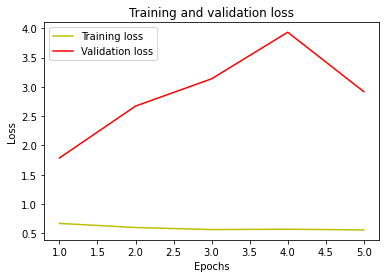

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

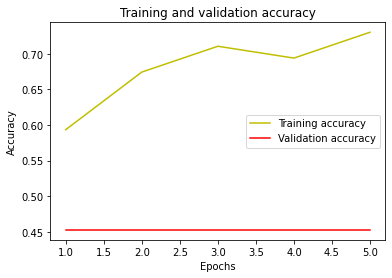

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Save model using pickle
with open("inceptionv3_model", "wb") as file:
    pickle.dump(history, file)

In [20]:
# prediction the newmodel
y_pred = new_model.predict(X_test)

In [21]:
# Evaluate model
test_loss, test_acc = new_model.evaluate(X_test, Y_test, verbose=0)
print("Test Score = ", test_loss)
print("Test Accuracy = ", test_acc)

Test Score =  2.9190338431177913
Test Accuracy =  0.45270270109176636
